# Parametric Survival Fit & PSA for Age-at-Onset in Autoimmune Disease: Generalized Gamma Workflow

### Background

This notebook fits parametric age-at-onset models (lognormal, Weibull, generalized gamma) using published summary statistics (min, Q1, median, Q3, max, mean; n). We select the best-fitting model via quantile matching and then run probabilistic sensitivity analysis (PSA) by sampling model parameters from an estimated multivariate normal (MVN) using a Cholesky factorization. Outputs include fitted parameters, uncertainty intervals for predefined age bands (0–12, 12–18, 18+), and diagnostic plots.

In [ ]:
# Todo (November 1, 2026):
# 1. Update title and subtitles
# 2. Update imported libraries
# 3. Improve formatting
# 4. Update inline comments
# 5. Refactor functions for better readability
# 6. Add error handling


## Necessary modules


In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import lognorm, weibull_min, gamma, genextreme # Importing necessary libraries for statistical distributions 
from scipy.optimize import minimize # Optimization for parameter fitting
from scipy.stats import probplot # Probability plot for visual assessment
from sklearn.metrics import mean_squared_error # Mean Squared Error for goodness-of-fit
from scipy.stats import gaussian_kde # Kernel Density Estimation for smooth CDF

## Fitting Generalized Gamma Model Based on Summary Statistics Derived from Literature

Background 

The summary statistics derived from literature informed three parametric survival model, consisting of log normal, weibull and generalized gamma. Of them, generalized gamma has the optimal fit of goodness, with lowest AIC. 

For better transparency and reproducibility, this section presents the procedure to achive the fitted generalized gamma, with fitted parameters.

The generalized Gamma distribution has three parameters to fit:
- a: shape parameter
- c: power parameter
- scale: scale parameter

In [ ]:
# import numpy as np
# from scipy.stats import gengamma
# from scipy.optimize import minimize

### Input Data

The summary statistics is derived from literature, which informs the parametric survival models.

In [97]:
median = 66
q1 = 61 
q3 = 72
min = 19
max = 88
mean = 67
size = 111

empirical_q = [q1, median, q3]

### Fitting Generalized Gamma Model

Apply quantile matching method to seek for the optimal model with smallest difference between predicted and observed quantiles.

In [98]:
# Define the quantile-matching objective function
def gengamma_objective(params):
    a, c, scale = params
    if a <= 0 or scale <= 0:
        return np.inf
    try:
        dist = gengamma(a=a, c=c, scale=scale)
        theo_q = dist.ppf([0.25, 0.5, 0.75])
        return np.sum((np.array(theo_q)- np.array(empirical_q))**2)
    except:
        return np.inf

In [99]:
# Run the optimization
initial_guess_gengamma = [2.0, 1.0, 10.0]
bounds_gengamma = [(0.01, None), (0.01, None), (0.01, None)]

result_gengamma = minimize(gengamma_objective, x0=initial_guess_gengamma, bounds=bounds_gengamma)
a_fit_gengamma, c_fit_gengamma, scale_fit_gengamma = result_gengamma.x

print(f"Fitted Generalized Gamma parameters:\n a = {a_fit_gengamma:.3f}, c = {c_fit_gengamma:.3f}, scale_fit_gengamma = {scale_fit_gengamma:.3f}")

Fitted Generalized Gamma parameters:
 a = 26.611, c = 1.583, scale_fit_gengamma = 8.409


/var/folders/b8/9ymtxc2j7rb00xx34s753cwc0000gn/T/ipykernel_51726/1451994867.py:9: RuntimeWarning: overflow encountered in square
  return np.sum((np.array(theo_q)- np.array(empirical_q))**2)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


### Visualization of Empirical and Fitted CDF

In [100]:
# Simulate and visualize
import matplotlib.pyplot as plt

In [101]:
# Simulate onset ages 
sim_ages_gengamma = gengamma(a = a_fit_gengamma, c = c_fit_gengamma, scale = scale_fit_gengamma).rvs(10000)

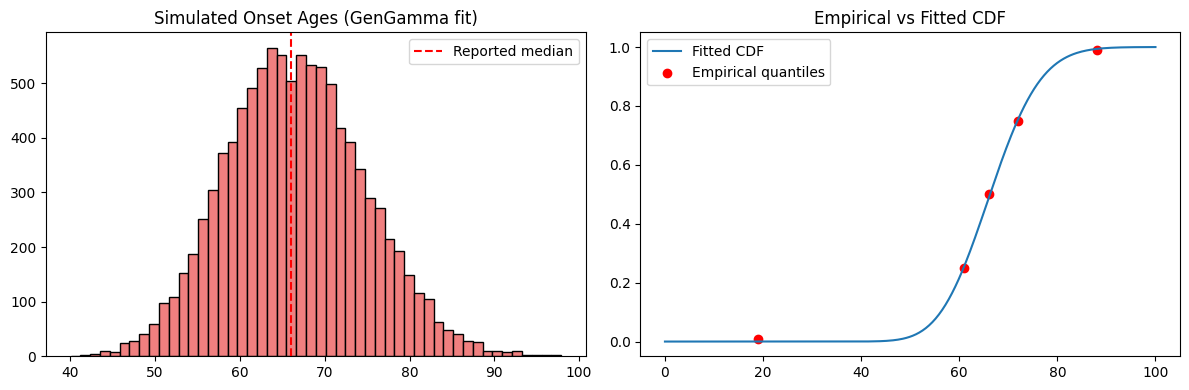

In [102]:
# Plot histogram and CDF
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

# Histogram
ax[0].hist(sim_ages_gengamma, bins=50, color='lightcoral', edgecolor='black')
ax[0].axvline(x=median, color='red', linestyle='--', label='Reported median')
ax[0].set_title('Simulated Onset Ages (GenGamma fit)')
ax[0].legend()

# CDF
x_gengamma = np.linspace(0, 100, 300)
model_cdf_gengamma = gengamma(a=a_fit_gengamma, c=c_fit_gengamma, scale=scale_fit_gengamma).cdf(x_gengamma)
ax[1].plot(x_gengamma, model_cdf_gengamma, label='Fitted CDF')
ax[1].scatter([min, q1, median, q3, max], [0.01, 0.25, 0.5, 0.75, 0.99], color='red', label='Empirical quantiles')
ax[1].set_title('Empirical vs Fitted CDF')
ax[1].legend()

plt.tight_layout()
plt.show()


In this case, the Generalized Gamma distribution shows the smallest squared difference, indicating the best fit among the three candidate distributions.

## Sensitivity analysis with Monte Carlo simulation

### Purpose

Monte Carlo simulation using fitted distribution parameters offers three key advantages:

- Continuous uncertainty representation rather than relying on only low, central, and high values.
- Faster and smoother calculations through the cumulative distribution function (CDF), without the need for inner resampling.
- More stable confidence intervals and compatibility with tornado analysis for identifying key drivers.

### Code for implementation

In [103]:
import numpy as np
import pandas as pd
from scipy.stats import gengamma, norm

In [ ]:
# The fitted model object from previous analysis
result_gengamma

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.10243077858152738
        x: [ 2.661e+01  1.583e+00  8.409e+00]
      nit: 88
      jac: [-1.463e-02  1.069e+00 -8.571e-02]
     nfev: 456
     njev: 114
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

### Getting Fitted Parameter

In [106]:
# Get the MLE
theta_hat = result_gengamma.x

print(theta_hat)

[26.61103626  1.58349596  8.40915197]


### Getting Covariance Matrix

Compute the Hessian numerically at the optimum

In [107]:
import numpy as np
from statsmodels.tools.numdiff import approx_hess

H = approx_hess(theta_hat, gengamma_objective)  # by default, central differences

In [108]:
# Invert the Hessian to get the variance-covariance matrix
vcov_matrix = np.linalg.inv(H)

print(vcov_matrix)

[[ 5.95129550e+02 -1.77608293e+01 -3.15062237e+02]
 [-1.77608293e+01  5.51055889e-01  9.63377691e+00]
 [-3.15062237e+02  9.63377691e+00  1.69340808e+02]]


In [109]:
# Multivariate normal sampling on fitted scale

from numpy.random import default_rng
rng = default_rng(123)
N = 5000

m = theta_hat  # MLE parameter vector
L = np.linalg.cholesky(vcov_matrix)  # Cholesky decomposition of variance-covariance matrix
Z = rng.standard_normal((N, len(m)))  # Standard normal samples

theta_draws = m + Z @ L.T  # MVN samples of parameters
mu_draws, log_sigma_draws, Q_draws = theta_draws.T

In [110]:
np.mean(log_sigma_draws)

1.5637918813315672

In [111]:
# Age bands (inclusive of lower, exclusive of upper)
age_bands = [(0, 12), (12, 18), (18, 100)]

### Calculating cumulative probability specific to predefined age bands

In [112]:
# Compute band probabilities for each parameter set via CDF
def band_probs_for_draw(a, c, s):
    F = gengamma(a=a, c=c, scale=s).cdf
    p0_12 = F(12.0) - F(0.0)
    p12_18 = F(18.0) - F(12.0)
    p18_100 = F(100.0) - F(18.0)
    return p0_12, p12_18, p18_100

gengamma(a=a, c=c, scale=s) constructs a "frozen" SciPy generalized Gamma distribution with given parameters. Appending .cdf returns that distribution's cumulative distribution function as a callable (i.e., can be called like a function).

What F is: a function F(x) that returns P(x <= x) for X ~ GenGamma(a,c,scale=s). It accepts acalars or numpy arrays and returns probabities in [0,1].



In [113]:
P = np.array([band_probs_for_draw(a, c, s) for a, c, s in zip(mu_draws, log_sigma_draws, Q_draws)]) # Shape (N, 3)

In [114]:
print(P[:10])

[[1.20059387e-02 7.33904212e-02 9.14603640e-01]
 [1.08145832e-25 8.45280534e-18 9.99985839e-01]
 [1.92092384e-12 1.54251855e-08 9.99999974e-01]
 [1.20756676e-18 5.23993223e-13 9.99994565e-01]
 [           nan            nan            nan]
 [1.70337946e-27 3.55365476e-19 9.99994112e-01]
 [3.04377245e-19 1.99256162e-13 9.99996554e-01]
 [1.00000000e+00 2.01283434e-13 0.00000000e+00]
 [           nan            nan            nan]
 [           nan            nan            nan]]


In [115]:
# Filter out NaNs in all three columns
P = P[~np.isnan(P).any(axis=1)]

In [116]:
print(P[:10])

[[1.20059387e-02 7.33904212e-02 9.14603640e-01]
 [1.08145832e-25 8.45280534e-18 9.99985839e-01]
 [1.92092384e-12 1.54251855e-08 9.99999974e-01]
 [1.20756676e-18 5.23993223e-13 9.99994565e-01]
 [1.70337946e-27 3.55365476e-19 9.99994112e-01]
 [3.04377245e-19 1.99256162e-13 9.99996554e-01]
 [1.00000000e+00 2.01283434e-13 0.00000000e+00]
 [8.17154984e-16 4.93084700e-11 9.99937577e-01]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.02810919e-20 2.75611355e-14 9.99997395e-01]]


### Results

In [117]:
# Summarize reults
summary = pd.DataFrame({
    'Age Band': ['0-12', '12-18', '18+'],
    'Mean': np.char.mod('%.2f%%', P.mean(axis=0)*100),
    "SD": np.char.mod('%.2f%%', P.std(axis=0)*100),
    "Median": np.char.mod('%.2f%%', np.median(P, axis=0)*100),
    "CI Lower (2.5%)": np.char.mod('%.2f%%', np.percentile(P, 2.5, axis=0)*100),
    "CI Upper (97.5%)": np.char.mod('%.2f%%', np.percentile(P, 97.5, axis=0)*100)
})

print(summary)


  Age Band    Mean      SD   Median CI Lower (2.5%) CI Upper (97.5%)
0     0-12   2.67%  14.00%    0.00%           0.00%           44.47%
1    12-18   1.95%   9.41%    0.00%           0.00%           23.81%
2      18+  95.38%  18.45%  100.00%           9.54%          100.00%


### Visualization of multivariate normal sampling

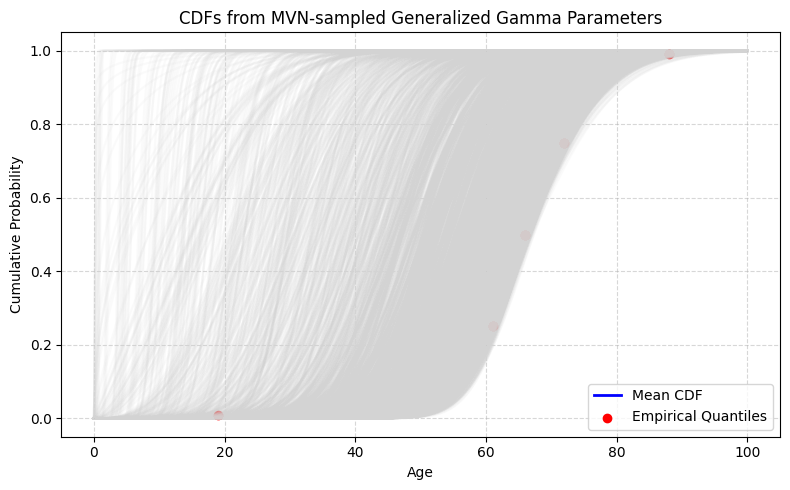

In [118]:
# Draw CDF for sampled parameters
x = np.linspace(0, 100, 300)
cdf_samples = [gengamma(a=a, c=c, scale=s).cdf(x) for a, c, s in zip(mu_draws, log_sigma_draws, Q_draws)]
import matplotlib.pyplot as plt
# Plot sampled CDFs
plt.figure(figsize=(8, 5))
for cdf in cdf_samples:
    plt.plot(x, cdf, color='lightgray', alpha=0.1)
# Plot mean CDF
mean_cdf = np.mean(cdf_samples, axis=0)
plt.plot(x, mean_cdf, color='blue', label='Mean CDF', linewidth=2)
# Plot empirical quantiles
plt.scatter([min, q1, median, q3, max], [0.01, 0.25, 0.5, 0.75, 0.99], color='red', label='Empirical Quantiles')
# Format plot
plt.title('CDFs from MVN-sampled Generalized Gamma Parameters')
plt.xlabel('Age')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
